# K-Fold
This topic was explained more precisely in Notion.

Website: [K-Fold Lecture by jeffheaton](https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_04_1_kfold.ipynb)
YouTube: [K-Fold Lecture by jeffheaton](https://www.youtube.com/watch?v=Q8ZQNvZwsNE&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)

In [1059]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8-ticks')
%config InlineBackend.figure_formats =['svg']

In [1060]:
import copy
class EarlyStopping:
    """
    Parameters
    ----------
    patience : float
        How long should we wait until there are no improvements
    minDelta : float
        Small values, The minimum change that should be considered as an improvement.
    restoreBestWeights : bool
        Restore the best weight settings, when there is no overfitting!
    """

    def __init__(self,patience=5, minDelta=0, restoreBestWeights=True):
        # Early Params
        self.patience = patience
        self.minDelta = minDelta
        self.restoreBestWeights = restoreBestWeights

        # Model Current State
        self.bestModel  = None
        self.bestLoss   = None
        self.counter    = 0
        self.status     = 'Learning'

    def __call__(self, model, val_loss):

        if self.bestLoss is None: # First Visit
            self.bestModel = copy.deepcopy(model.state_dict())
            self.bestLoss  = val_loss

        elif self.bestLoss - val_loss >= self.minDelta: # check if there is any improvement, learning would be positive otherwise we should wait for an improvement
            self.bestModel   = copy.deepcopy(model.state_dict())
            self.bestLoss   = val_loss
            self.counter    = 0 # reset counting
            self.status     = f'Learning'

        else: # there are no improvements
            self.counter   += 1
            self.status     = f'Waiting.'
            if self.counter >= self.patience: # Have we waited enough ?
                self.status     = f'*Finished due to no improvements on validation for {self.counter} epochs.'
                if self.restoreBestWeights: # Restore Best weights ?
                    model.load_state_dict(self.bestModel)
                return True
        return False

# Data

In [1061]:
df = pd.read_csv('https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv', na_values=['NA','?'])
df = df.drop(columns=['id'])

## Data pre processing

In [1062]:
X_cols = df.keys().drop('product')
y_cols = 'product'
encode_cols = ['job','area','product']
zscore_cols = df.keys().drop(encode_cols)
toDrop = np.concatenate((encode_cols,zscore_cols)) # New cols are renamed. old ones have to be deleted

## Fill nulls

In [1063]:
df['income'] = df['income'].fillna(df['income'].median())

## Convert categorical into numbers

In [1064]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in encode_cols:
    df[f'encoded_{col}'] = le.fit_transform(df[col].values)
    df.drop(columns=col,inplace=True)

## Data norm ZScore

In [1065]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   income           2000 non-null   float64
 1   aspect           2000 non-null   float64
 2   subscriptions    2000 non-null   int64  
 3   dist_healthy     2000 non-null   float64
 4   save_rate        2000 non-null   int64  
 5   dist_unhealthy   2000 non-null   float64
 6   age              2000 non-null   int64  
 7   pop_dense        2000 non-null   float64
 8   retail_dense     2000 non-null   float64
 9   crime            2000 non-null   float64
 10  encoded_job      2000 non-null   int32  
 11  encoded_area     2000 non-null   int32  
 12  encoded_product  2000 non-null   int32  
dtypes: float64(7), int32(3), int64(3)
memory usage: 179.8 KB


In [1066]:
for col in df.keys().drop('encoded_product'):
    df[f'scaled_{col}'] = stats.zscore(df[col])
    df.drop(columns=col,inplace=True)

## Drop old columns, we replaced them with new names 'scaled'

In [1067]:
df.describe()

,encoded_product,scaled_income,scaled_aspect,scaled_subscriptions,scaled_dist_healthy,scaled_save_rate,scaled_dist_unhealthy,scaled_age,scaled_pop_dense,scaled_retail_dense,scaled_crime,scaled_encoded_job,scaled_encoded_area
count,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03
mean,1.572000,-4.440892e-17,3.552714e-17,-6.039613e-17,3.161915e-16,-1.865175e-17,-2.247091e-16,-2.611245e-16,3.250733e-16,1.181277e-16,-4.307665e-17,-1.083578e-16,-3.730349e-17
std,1.018005,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00
min,0.000000,-3.698464e+00,-1.417904e+00,-1.255928e+00,-1.273096e+00,-2.863493e+00,-1.481105e+00,-4.546792e+00,-5.063708e+00,-3.688158e+00,-1.509179e+00,-2.092721e+00,-1.038578e+00
25%,1.000000,-5.264666e-01,-8.710929e-01,-2.084485e-01,-7.604372e-01,-6.971694e-01,-7.868475e-01,-4.959572e-01,-5.378793e-01,-5.946605e-01,-7.341201e-01,-6.145698e-01,-1.038578e+00
50%,1.000000,1.651291e-01,-2.525686e-01,-2.084485e-01,-2.145502e-01,-2.845363e-01,-2.363525e-01,3.142098e-01,1.307090e-01,-1.740092e-03,-1.893297e-01,2.950617e-01,-1.116900e-01
75%,2.000000,7.226491e-01,9.755160e-01,8.390315e-01,5.117169e-01,3.859925e-01,6.086614e-01,8.543211e-01,6.964376e-01,7.200760e-01,4.412394e-01,8.635814e-01,8.151980e-01
max,6.000000,3.157229e+00,1.800215e+00,3.981471e+00,4.138305e+00,5.784609e+00,2.769984e+00,1.664488e+00,1.570745e+00,2.679291e+00,3.835791e+00,1.545805e+00,1.742086e+00


# Prepare X,y

In [1068]:
X_cols = df.keys().drop('encoded_product')
X_cols

Index(['scaled_income', 'scaled_aspect', 'scaled_subscriptions',
       'scaled_dist_healthy', 'scaled_save_rate', 'scaled_dist_unhealthy',
       'scaled_age', 'scaled_pop_dense', 'scaled_retail_dense', 'scaled_crime',
       'scaled_encoded_job', 'scaled_encoded_area'],
      dtype='object')

In [1069]:
y_cols = 'encoded_product'

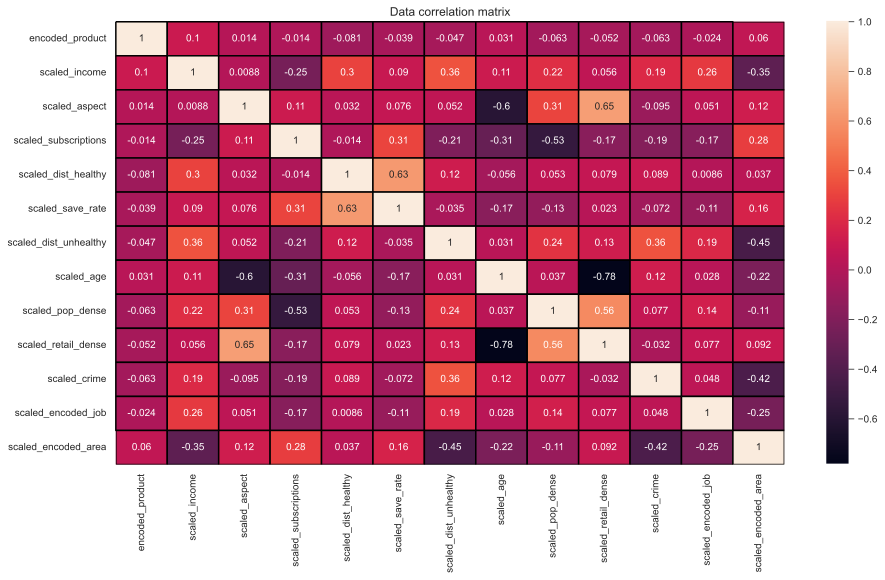

In [1070]:
# Inspect the correlation matrix
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, lw=1.5,linecolor='k')
plt.title('Data correlation matrix')
plt.show()

# Methods

In [1071]:
def createModel(nFeatures,learningEpochs = 500,learningRate=0.01):
    model = nn.Sequential(
        nn.Linear(nFeatures, 32),
        nn.BatchNorm1d(32),
        nn.Tanh(),

        nn.Linear(32, 32),
        nn.BatchNorm1d(32),
        nn.Tanh(),

        nn.Linear(32, 32),
        nn.BatchNorm1d(32),
        nn.Tanh(),

        nn.Linear(32, 7),
        nn.LogSoftmax(dim=1)
    )
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),learningRate)
    es = EarlyStopping(patience=80,minDelta=0,restoreBestWeights=True)

    return model,loss_func,optimizer,es

# Cross-Validation [ K-Fold ]

In [1072]:
torch.manual_seed(42)

## K-Fold Settings

In [1073]:
from sklearn.model_selection import StratifiedKFold
n_folds = 5
k_fold  = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=12)

## Class balancing

In [1074]:
from imblearn import over_sampling, under_sampling
uSample = over_sampling.RandomOverSampler()
X_resmapled, y_resampled = uSample.fit_resample(df[X_cols],df['encoded_product'])
df_resampled = pd.concat([X_resmapled,y_resampled],axis=1)

## Prepare tensors

In [1075]:
models_state = []
models_perf = np.zeros((n_folds,3))

In [1076]:
features = df_resampled[X_cols].to_numpy()
labels   = df_resampled['encoded_product'].to_numpy()

In [1077]:
X = torch.tensor(df_resampled[X_cols].values, dtype=torch.float)
y = torch.tensor(df_resampled[y_cols].values, dtype=torch.int64)
X.shape,y.shape

(torch.Size([6741, 12]), torch.Size([6741]))

# Check for classes balancing during folds

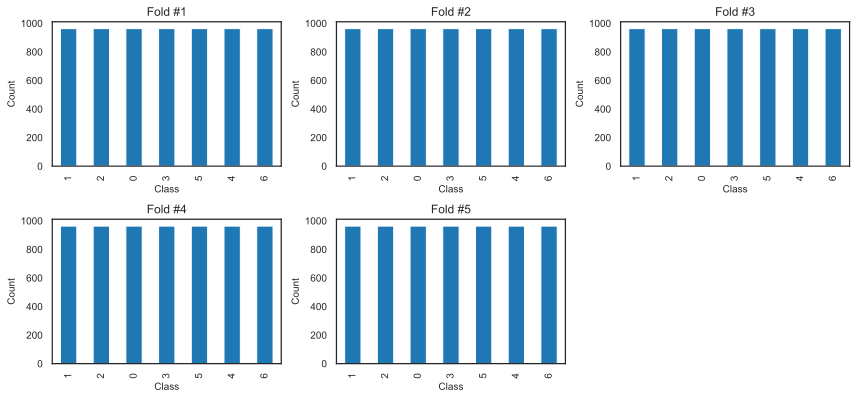

In [1078]:
plt.figure(figsize=(12,8))
for fold_i,(trainIdx,valIdx) in enumerate(k_fold.split(X,y)):
    plt.subplot(3,3,fold_i+1)
    df_resampled.encoded_product.value_counts().plot(kind='bar')
    plt.title(f'Fold #{fold_i+1}')
    plt.xlabel('Class')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Training and Evaluation

In [1079]:
import sklearn.metrics as metrics
from tqdm import tqdm

X_train_size = 0
tAccuracy = []
vAccuracy = []

for fold_i,(trainIdx,valIdx) in enumerate(k_fold.split(X,y)):

    # Data & DataLoaders
    X_train, X_val, y_train, y_val = X[trainIdx],X[valIdx],y[trainIdx],y[valIdx]
    X_train_size = X_train.shape[1]

    train_ds = TensorDataset(X_train,y_train)
    val_ds   = TensorDataset(X_val,y_val)
    train_dl = DataLoader(train_ds,batch_size=64,shuffle=True,drop_last=True)
    val_dl   = DataLoader(val_ds,batch_size=len(y_val))

    # Model settings
    model, loss_func, optimizer ,es = createModel(X_train_size,500,0.01)
    epoch_pb = tqdm(range(500),leave=True,position=0)

    # Training
    for epoch_i in epoch_pb:
        model.train()
        tBatchAcc = []
        tBatchLoss = []

        # Batch Training
        for batch_X, batch_y in train_dl:

            # Forward & Loss
            yHat = model(batch_X)
            tloss = loss_func(yHat,batch_y)
            tBatchLoss.append(tloss)

            # Backward
            optimizer.zero_grad()
            tloss.backward()
            optimizer.step()

            # Calculate Losses and accuracies
            TP = torch.argmax(yHat,axis=1)
            tBatchAcc.append( metrics.accuracy_score(batch_y,TP)*100 )
        # End Of training Batches

        # Validation
        model.eval()
        with torch.no_grad():
            # Evaluation
            X_val, y_val = next(iter(val_dl))
            yHat = model(X_val)
            vloss = loss_func(yHat,y_val)

            # Accuracy
            TP = torch.argmax(yHat,axis=1)
            vAcc = metrics.accuracy_score(y_val,TP)*100

        # Reports before checking for improvements
        tAcc = np.mean(tBatchAcc)
        epoch_pb.set_description(f'Fold #{fold_i+1} \tEpoch: {epoch_pb.n:2d}, [tLoss {tloss:.9f}: {tAcc:.3f}%\t vLoss {vloss:.9f}: {vAcc:.3f}%]\t {es.status}-{es.counter+1}\t')

        # Check For any improvements
        if es(model, vloss):
            epoch_pb.set_postfix_str(f'Training Break due to no improvements, Best vLoss {es.bestLoss:.9f}')
            models_state.append(model.state_dict())
            models_perf[fold_i,:] = es.bestLoss, vAcc ,tAcc
            break

Fold #1 	Epoch: 121, [tLoss 0.065598980: 96.019%	 vLoss 0.261309952: 92.439%,	]	 Waiting.-80	:  24%|██▍       | 121/500 [00:31<01:38,  3.85it/s, Training Break due to no improvements, Best vLoss 0.217285082]
Fold #2 	Epoch: 141, [tLoss 0.076561436: 95.722%	 vLoss 0.295310974: 91.172%,	]	 Waiting.-80	:  28%|██▊       | 141/500 [00:36<01:32,  3.90it/s, Training Break due to no improvements, Best vLoss 0.202047482]
Fold #3 	Epoch: 120, [tLoss 0.055807516: 95.740%	 vLoss 0.268532872: 91.766%,	]	 Waiting.-80	:  24%|██▍       | 120/500 [00:30<01:36,  3.92it/s, Training Break due to no improvements, Best vLoss 0.207288980]
Fold #4 	Epoch: 128, [tLoss 0.031989574: 95.815%	 vLoss 0.236918941: 92.582%,	]	 Waiting.-80	:  26%|██▌       | 128/500 [00:33<01:35,  3.88it/s, Training Break due to no improvements, Best vLoss 0.186008409]
Fold #5 	Epoch: 118, [tLoss 0.157926753: 96.652%	 vLoss 0.287178755: 91.395%,	]	 Waiting.-80	:  24%|██▎       | 118/500 [00:30<01:38,  3.88it/s, Training Break due to n

# Results

In [1080]:
pd.DataFrame(models_perf,columns=['Validation Error','Validation Accuracy','Training Accuracy'])

,Validation Error,Validation Accuracy,Training Accuracy
0,0.217285,92.438844,96.019345
1,0.202047,91.172107,95.721726
2,0.207289,91.765579,95.740327
3,0.186008,92.581602,95.814732
4,0.234629,91.394659,96.651786
